In [1]:
from __future__ import print_function

import pandas as pd
import scipy as sp

from abtools.bayesian import ARPUModel

%matplotlib inline

In [2]:
mu = 9
size = 300
delta_true = .05

arppu_a = pd.Series(sp.stats.wald.rvs(loc=mu, size=size, random_state=8228))
arppu_b = pd.Series(sp.stats.wald.rvs(loc=mu*(1+delta_true), size=size, random_state=8228))

print('ARPPU')
print('Mean: %.4f' % arppu_a.mean())
print('Mean: %.4f' % arppu_b.mean())
print('B больше A на %.4f = %d%%' % (arppu_b.mean()- arppu_a.mean(), 
                                    (arppu_b.mean()/arppu_a.mean()-1)*100))

p = .03
size = 10000
delta_true = .05

c_a = pd.Series(sp.stats.bernoulli.rvs(p=p, size=size, random_state=8228))
c_b = pd.Series(sp.stats.bernoulli.rvs(p=p*(1+delta_true), size=size, random_state=8228))

print('Mean: %.4f' % (c_a.mean()))
print('Mean: %.4f' % (c_b.mean()))
print('y2 больше y1 на %.4f = %d%%' % (c_b.mean()- c_a.mean(), (c_b.mean()/c_a.mean()-1)*100))

ARPPU
Mean: 9.9796
Mean: 10.4296
B больше A на 0.4500 = 4%
Mean: 0.0303
Mean: 0.0320
y2 больше y1 на 0.0017 = 5%


In [3]:
model = ARPUModel(c_a, c_b, arppu_a, arppu_b)

In [4]:
model.fit(samples=10000, n_init=2500)

Average ELBO = -7,332.3: 100%|██████████| 2500/2500 [00:00<00:00, 3391.09it/s]
Finished [100%]: Average ELBO = -7,299.4
100%|██████████| 10000/10000 [00:07<00:00, 1405.82it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1790ad3c8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fc173d5ddd8>], dtype=object)

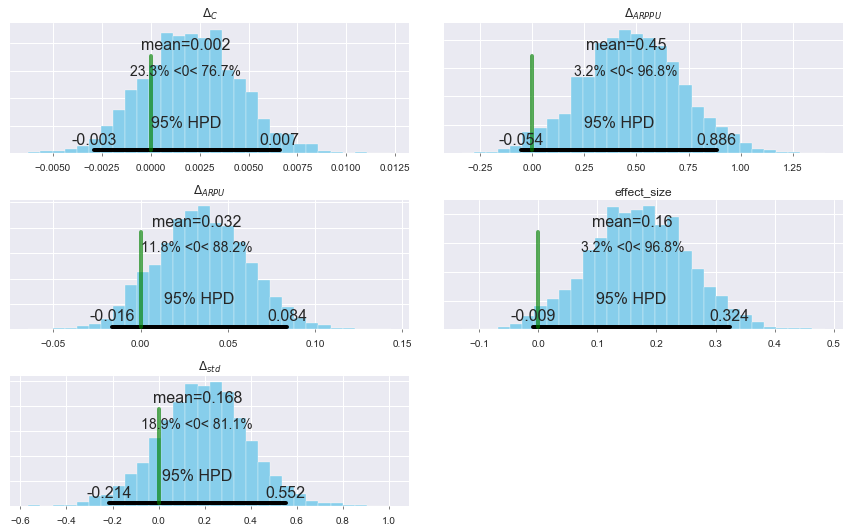

In [5]:
model.plot_deltas(1000)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc170bd0f28>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fc180d605c0>], dtype=object)

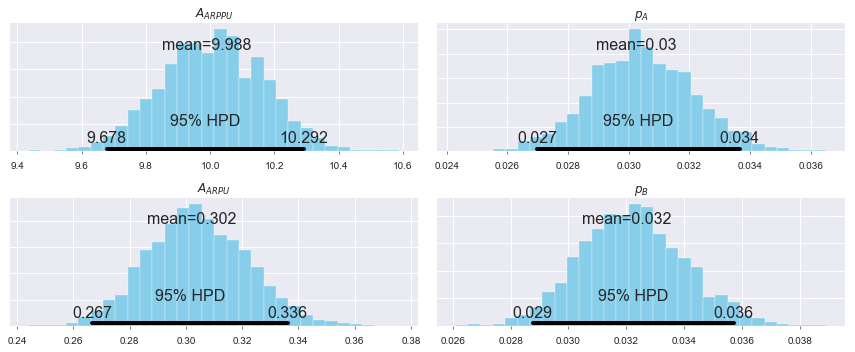

In [6]:
model.plot_params(1000)